# Predicting View Engagement
With the accelerating popularity of online educational experiences, the role of online lectures continues to increase in scope and importance. This impressive volume of content has led to the challenge of which of these videos provides the best learning experiences. 

One critical property of a successful video is engagement: how interesting it is for viewers. Engagement is critical for learning, whether the instruction is coming from a video or any other source. For this project, we created classifiers that predict how engaging an educational video is likely to be for viewers, based on a set of features extracted from the video's transcript, audio track, hosting site, and other sources.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import recall_score, precision_score, accuracy_score

np.random.seed(0)

## 1. Load and Prepare Data

The data for this project consists of educational video features collected by Sahan Bulathwela at University College London from the Virtual Learning Environment (VLE) Dataset (https://github.com/sahanbull/VLE-Dataset).

In [2]:
data = pd.read_csv('./assets/VLE_dataset.csv')
data.head()

,id,fold,categories,word_count,title_word_count,document_entropy,easiness,fraction_stopword_presence,fraction_stopword_coverage,preposition_rate,...,silent_period_rate,min_engagement,max_engagement,med_engagement,mean_engagement,sd_engagement,num_learners,num_views,avg_star_rating,num_star_ratings
0,1,1,stem,2668,9,7.753995,75.583936,0.553664,0.428135,0.121392,...,0.0,0.030241,1.0,0.502923,1.000000,1.574152,53,1899,-1.0,0
1,2,1,misc,7512,6,8.305269,86.870523,0.584498,0.602446,0.095885,...,0.0,0.008136,1.0,0.011989,0.165811,0.368124,7,1982,-1.0,0
2,3,1,stem,4264,3,7.965583,81.915968,0.605685,0.525994,0.118294,...,0.0,0.009563,1.0,0.041627,0.199148,0.358510,39,3561,5.0,1
3,4,1,stem,2869,9,8.142877,80.148937,0.593664,0.504587,0.122590,...,0.0,0.016787,1.0,0.064989,0.317020,0.662013,36,3030,-1.0,0
4,5,1,misc,4840,9,8.161250,76.907549,0.581637,0.559633,0.130700,...,0.0,0.014288,1.0,0.052154,0.147820,0.263750,25,2864,-1.0,0


Not all of the columns will be helpful for classifying viewer engagement, so we trimmed the number of columns down these 8:
`['title_word_count', 'document_entropy', 'freshness', 'easiness', 'fraction_stopword_presence', 'normalization_rate', 'speaker_speed', 'silent_period_rate']`. This is consist with the original task. 

In [3]:
df = data[['title_word_count', 'document_entropy', 'freshness', 'easiness',
       'fraction_stopword_presence', 'normalization_rate', 'speaker_speed',
       'silent_period_rate']].copy()
df.head()

,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate
0,9,7.753995,16310,75.583936,0.553664,0.034049,2.997753,0.0
1,6,8.305269,15410,86.870523,0.584498,0.018763,2.635789,0.0
2,3,7.965583,15680,81.915968,0.605685,0.030720,2.538095,0.0
3,9,8.142877,15610,80.148937,0.593664,0.016873,2.259055,0.0
4,9,8.161250,14920,76.907549,0.581637,0.023412,2.420000,0.0


This data isn't labeled. When the assignment was presented in my certification course, they provided a much smaller subset of the full data set, which was already labeled. After comparing the two data sets, I determined instances were labeled 'engaged' if the median engagement level was at least 30%. For all others, they were considered 'not engaged'. We used the same cut-off to label our data.  

In [4]:
df['engagement'] = 0
df.loc[data['med_engagement'] >= 0.3, 'engagement'] = 1
df.head()

,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,engagement
0,9,7.753995,16310,75.583936,0.553664,0.034049,2.997753,0.0,1
1,6,8.305269,15410,86.870523,0.584498,0.018763,2.635789,0.0,0
2,3,7.965583,15680,81.915968,0.605685,0.030720,2.538095,0.0,0
3,9,8.142877,15610,80.148937,0.593664,0.016873,2.259055,0.0,0
4,9,8.161250,14920,76.907549,0.581637,0.023412,2.420000,0.0,0


The data seems a little unbalanced, so we checked the distribution of engaged/disengaged viewers in the data.

In [5]:
# Calculate number of rows 
total = len(df)

# Calculate proportions for both classes 
proportions = df['engagement'].value_counts() / total

proportions

engagement
0    0.902754
1    0.097246
Name: count, dtype: float64

Only about 10% is engaged viewer data, so the data is relatively skewed. We'll keep this in mind during the analysis process. 

Next, the data was split into training and test data sets.

In [6]:
# Separate attributes and target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split into training/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## 2. Create Baseline
As a baseline, we created a majority-vote classifier. Since the majority of the instances are disengaged viewers, and 
about 90% of the data is assigned to this class, we'd expect a high score. Due to the imbalance of classes in the data, we chose to use the F-1 score to evaluate the classifiers, because it doesn't assume an equal number of positive/negative examples. 

In [7]:
# Create dummy classifier, use most frequent class 0
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
# Make predictions with test data
y_dummy_predictions = dummy_majority.predict(X_test)

# Calculated weighted F-1 score
dummy_f1_score = f1_score(y_test, y_dummy_predictions, average='weighted')

print('Weighted F-1 Score: ', dummy_f1_score)

Weighted F-1 Score:  0.8499780035851628


The dummy classifier sets the F-1 score baseline at about 85.0%. We'll be evaluating the other classifiers against this score. 

## 3. Logistic Regression Classifier
The first classifier we created was a logistic regression classifier. 

For some of the classifiers, including the logistic regression model, the data should be normalized, so we used a min-max scaler. 

In [8]:
# Create scaler
scaler = MinMaxScaler()

# Normalize the X data 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

To find the best combination of `penalty` and `C` hyperparameters, we used cross validation. 

In [23]:
# Range of penalties and 'C' values to try
grid_values = {'penalty': ['l1', 'l2'], 
               'C': [0.01, 1, 10, 100]}

# Create model using 'liblinear' solver
lr = LogisticRegression(solver='liblinear')

# Metric to optimize over grid parameters: F-1 Scoring
grid_lr = GridSearchCV(lr, param_grid=grid_values, scoring='f1')
grid_lr.fit(X_train_scaled, y_train)

# Best combination of options
params = grid_lr.best_params_
params

{'C': 100, 'penalty': 'l1'}

In [10]:
# Create classifier with best hyperparameters
best_lr = LogisticRegression(solver='liblinear', C=params['C'], 
                             penalty=params['penalty'])
# Train model 
best_lr.fit(X_train_scaled, y_train)

# Make predictions with test data 
best_lr_predicted = best_lr.predict(X_test_scaled)

# Calculated weighted F-1 score
lr_f1_score = f1_score(y_test, best_lr_predicted, average='weighted')

print('Weighted F-1 Score: ', lr_f1_score)

Weighted F-1 Score:  0.8901816566258641


The Logistic Regression classifier scored a 89.0%, which is an improvement over the baseline.

## 4. k-Nearest Neighbor Classifier
The next classifier we examined was a k-Nearest Neighbor model and used cross validation to determine the best combination of the `n_neighbors` and `weights` hyperparameters.

In [24]:
# Range of neighbors and weight types to try
grid_values = {'n_neighbors': [1, 3, 5, 7, 9], 
               'weights': ['uniform', 'distance']}

# Create default model 
knn = KNeighborsClassifier()

# Metric to optimize over grid parameters: F-1 Score
grid_knn = GridSearchCV(knn, param_grid=grid_values, scoring='f1')
grid_knn.fit(X_train_scaled, y_train)

# Best combination of hyperparameters 
params = grid_knn.best_params_
params

{'n_neighbors': 3, 'weights': 'uniform'}

In [12]:
# Create classifier with best hyperparameters
best_knn = KNeighborsClassifier(n_neighbors=params['n_neighbors'], 
                                weights=params['weights'])
# Train model 
best_knn.fit(X_train_scaled, y_train)

# Make predictions with test data 
best_knn_predicted = best_knn.predict(X_test_scaled)

# Calculated weighted F-1 score
knn_f1_score = f1_score(y_test, best_knn_predicted, average='weighted')

print('Weighted F-1 Score: ', knn_f1_score)

Weighted F-1 Score:  0.89557973820884


The k-Nearest Neighbor classifier scored a 89.5%, which was better than both the baseline and the Logistic Regression classifier.

## 5. Support Vector Machine (SVM) Classifier
For the third model, we looked at the performance of a SVM model. 

In [18]:
## Set of hyperparameters used in cross validation
grid_values = {'C': [10, 100],
               'gamma': [1, 10]}
# Create model 
svm = SVC(kernel='poly')

# Metric to optimize over grid parameters: F1-score
grid_svm = GridSearchCV(svm, param_grid=grid_values, scoring='f1')
grid_svm.fit(X_train_scaled, y_train)

# Best combination of hyperparameters
params = grid_svm.best_params_
params

{'C': 100, 'gamma': 10}

In [19]:
# Create classifier with best hyperparameters
best_svm = SVC(kernel='poly',
               C=params['C'],
               gamma=params['gamma'])
# Train model 
best_svm.fit(X_train_scaled, y_train)

# Make predictions with test data 
best_svm_predicted = best_svm.predict(X_test_scaled)

# Calculated weighted F-1 score
svm_f1_score = f1_score(y_test, best_svm_predicted, average='weighted')

print('Weighted F-1 Score: ', svm_f1_score)

Weighted F-1 Score:  0.906801406235055


The SVM classifier scored 90.7%, which is better than the baseline and the previous two models. 

## 6. Decision Tree Classifier
We tried  a Decision Tree model for the fourth classifier. We used cross validation to determine the best `max_depth` and `criterion` hyperparameters. 

In [13]:
# Set of hyperparameters used in cross validation
grid_values = {'max_depth': [2, 3, 4, 5], 
               'criterion': ['gini', 'entropy', 'log_loss']}
# Create model 
dt = DecisionTreeClassifier()

# Metric to optimize over grid parameters: F1-score
grid_dt = GridSearchCV(dt, param_grid=grid_values, scoring='f1')
grid_dt.fit(X_train, y_train)

# Combination of best hyperparameters 
params = grid_dt.best_params_
params

{'criterion': 'entropy', 'max_depth': 4}

In [14]:
# Create classifier with best hyperparameters
best_dt = DecisionTreeClassifier(max_depth=params['max_depth'],
                                 criterion=params['criterion'])
# Train model 
best_dt.fit(X_train_scaled, y_train)

# Make predictions with test data 
best_dt_predicted = best_dt.predict(X_test_scaled)

# Calculated weighted F-1 score
dt_f1_score = f1_score(y_test, best_dt_predicted, average='weighted')

print('Weighted F-1 Score: ', dt_f1_score)

Weighted F-1 Score:  0.9108040102710971


The score of 91.1% for the Decision Tree classifier, scored better than the baseline and other three models. 

## 7. Random Forest
Finally, we tried a Random Forest classifier as our last model and used cross validation to find the best values for the `n_estimators` and `max_depth` hyperparameters. 

In [15]:
# Set of hyperparameters used in cross validation
grid_values = {'n_estimators': [2, 4, 6], 
               'max_depth': [2, 3, 4]}
# Creater model 
rf = RandomForestClassifier()

# Metric to optimize over grid parameters: F1-score
grid_rf = GridSearchCV(rf, param_grid=grid_values, scoring='f1')
grid_rf.fit(X_train, y_train)

# Combination of best hyperparameters
params = grid_rf.best_params_
params

{'max_depth': 4, 'n_estimators': 2}

In [16]:
# Create classifier with best hyperparameters
best_rf = RandomForestClassifier(n_estimators=params['n_estimators'],
                                 max_depth=params['max_depth'])
# Train model 
best_rf.fit(X_train_scaled, y_train)

# Make predictions with test data 
best_rf_predicted = best_rf.predict(X_test_scaled)

# Calculated weighted F-1 score
rf_f1_score = f1_score(y_test, best_dt_predicted, average='weighted')

print('Weighted F-1 Score: ', rf_f1_score)

Weighted F-1 Score:  0.9108040102710971


The Random Forest classifier scored 91.1%, which is the same as the Decision Tree model, but better than the baseline and the other two models. 

## 8. Conclusion
To summarize, here are the overall results of our classifiers: 

In [20]:
# Create data frame with results 
results = pd.DataFrame({'F-1 Score': [dummy_f1_score, lr_f1_score, knn_f1_score, svm_f1_score,
                                                       dt_f1_score, rf_f1_score]},
                       index=['Dummy', 'Logistic Regression', 'k-Nearest Neighbor', 'Support VectorMachine', 
                              'Decision Tree', 'Random Forest'])
results

,F-1 Score
Dummy,0.849978
Logistic Regression,0.890182
k-Nearest Neighbor,0.895580
Support VectorMachine,0.906801
Decision Tree,0.910804
Random Forest,0.910804


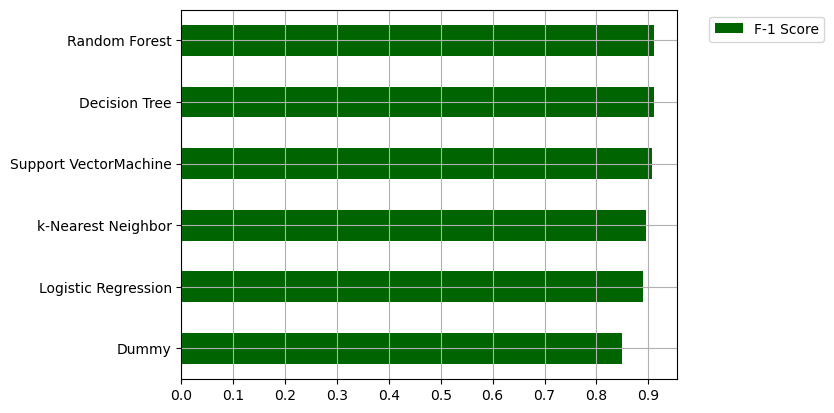

In [34]:
# Plot results 
ax = results.plot.barh(color='darkgreen')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
loc = matplotlib.ticker.MultipleLocator(0.1)
ax.xaxis.set_major_locator(loc); 

Overall, all five of our classifier performed better than the baseline, and the best performing models were the Decision Tree and Random Forest classifiers, which had the same score. 

Interestingly, the Decision Tree classifier used the Gini index as its evaluation criterion, which is the default criterion, and the Random Forest classifier used entropy for its evaluation criterion, which was found to perform better using cross validation. However, both had a maximum tree depth of 4, which were found using cross validation. 

I think the reason that the Random Forest classifier didn't outperform the Decision Tree classifier is the number of attributes. The Random Forest model generally performs better than the Decision Tree model when there a large number of attributes. Too many attributes often leads to deep and, many times, overfitted Decision Trees. Random Forests are able to break in multiple trees and more efficiently differentiate between the classes. With only eight attributes, the Decision Tree was able to perform just as well in a single tree.     